# Катастрофа "Титаника": машинное обучение в деле

## Постановка задачи

Крушение парохода «Титаник» — морская катастрофа, произошедшая в ночь с 14 на 15 апреля 1912 года в северной части Атлантического океана. Трагедия случилась под конец пятого дня следования «Титаника» по трансатлантическому маршруту Саутгемптон—Нью-Йорк. Самый большой на тот момент океанский лайнер с 2224 людьми на борту по касательной столкнулся с айсбергом и получил серьёзные повреждения обшивки корпуса. Спустя 2 часа 40 минут "Титаник" полностью ушёл под воду. Катастрофа унесла жизни 1502  человек.  

В данном [соревновании](https://www.kaggle.com/c/titanic) нам предлагается исследовать данные людей, находящихся на борту судна, и определить, какие пассажиры подвергались меньшей опасности и выжили в результате катастрофы. Несомненно, в этом был элемент удачи, однако некоторые категории пассажиров, например, женщины, дети, пассажиры люкс-класса имели большие шансы остаться в живых.

Перед нами классическая задача бинарной классификации, где каждому пассажиру соответствует целевая переменная, принимающая два возможных значения: 
- 1, если пассажир выжил в катастрофе; 
- 0, в противоположенном случае.

## Данные

Данные для анализа представлены в виде csv файла, со следующей информацией:

Признак | Пояснение | Значения | Тип данных
---|---|---|---
Survival|Целевая переменная каждого пассажира|0 = не выжил, 1 = выжил | Целое число
PassengerId | Уникальный номер пассажира в датасете |- | Целое число
Pclass|Класс обслуживания пассажира |1 = первый, 2 = второй, 3 = третий | Целое число
Name | Имя пассажира | -| Строка
Sex|Пол пассажира | male = мужской, female = женский| Строка
Age|Возраст пассажира, лет |- |Вещественное число
SibSp| Число сиблингов/супругов на борту | - |Целое число
Parch|Число родителей/детей на борту | - |Целое число
Ticket|Номер билета| - | Строка
Fare|Цена билета| - | Вещественное число
Cabin|Номер каюты| - | Строка
Embarked|Порт посадки на судно|C = Шербур, Q = Куинстаун, S = Саутгемптон | Строка

Приступим к анализу этих данных.

In [1]:
# загрузка библиотек
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

from sklearn import preprocessing, model_selection, metrics
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis

import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

### Предварительная обработка данных

Для экономии времени не будем подробно описывать полный процесс предварительного исследования и обработки этих данных. Остановимся лишь на принципиально важных моментах:
0. Исключаем из анализа признаки, которые либо слабо коррелируют с выживанием, либо не поддаются анализу, либо имеют много пустых значений:
  * PassengerId - порядоковый номер пассажира в списке;
  * Name - имя пассажира;
  * Ticket - номер билета;
  * Fare - стоимость билета определяют факторы, не связанные с катастрофой;
  * Cabin - номер каюты указан лишь для 23% пассажиров;
  * Embarked - порт посадки на судно.
1. Значимые признаки в датасете:
  * вещественные (Age, SibSp, Parch);
  * бинарные (Survival, Sex);
  * категориальные-порядковые (Pclass).
2. Отсутствующие значения Age заполняем средним возрастом по датасету.
3. Бинарный признак Sex кодируем 0 и 1.
4. Добавляем признак, определяющий количество родственников на борту, _Family = SibSp + Parch_.

In [3]:
def preprocessing_data(name):
    #загрузка датасета
    df = pd.read_csv(name)
    
    #заполнение пропущенных значений возраста средним значением
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    
    #обработка бинарных признаков: замена вещественными значениями
    df['Sex'].replace(to_replace=['male', 'female'], value=[0., 1.], inplace=True)
    
    #добавление признака 'Family' = 'SibSp'+'Parch'
    df['Family'] = df['SibSp'] + df['Parch']
    
    #исключаем иррелевантные признаки
    #PassengerId не нужен в обучающем датасете, но потребуется в тестовом, оставляем его
    df.drop(['Name', 'Ticket', 'Fare', 'Cabin', 'Embarked'], axis=1, inplace=True)
    
    return df

In [4]:
df_train = preprocessing_data('train.csv')
df_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Family
0,1,0,3,0.0,22.0,1,0,1
1,2,1,1,1.0,38.0,1,0,1
2,3,1,3,1.0,26.0,0,0,0
3,4,1,1,1.0,35.0,1,0,1
4,5,0,3,0.0,35.0,0,0,0


Убедимся, что предобработка прошла успешно.

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null float64
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Family         891 non-null int64
dtypes: float64(2), int64(6)
memory usage: 55.7 KB


### Визуализация данных

Прежде чем приступать к анализу, посмотрим на распределение различных признаков в графической форме.

In [6]:
#создание набора общих графиков
def create_axes(sbp, data, tlt, ylbl, xtcks):
    ax = fig.add_subplot(1, 4, sbp)
    data.plot(kind='bar', ax=ax, width=.5, color='tab:blue', align='center')
    ax.grid(axis='y')
    ax.set_title(tlt)
    ax.set_ylim(0,1)
    ax.set_ylabel(ylbl)
    ax.tick_params(axis='x', labelrotation=0)
    ax.set_xticklabels(labels=xtcks)

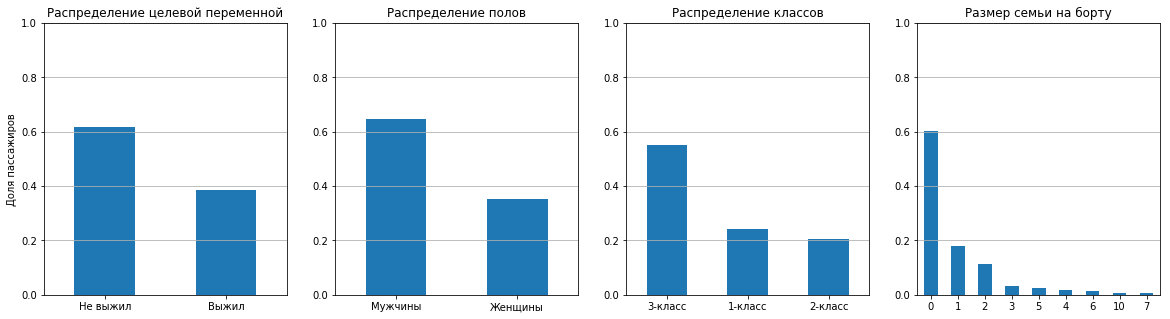

In [7]:
fig = plt.figure(figsize=(20,5), frameon=True)

#результат плавания
data = df_train['Survived'].value_counts()
create_axes(1, data/df_train.shape[0], 'Распределение целевой переменной', 'Доля пассажиров', ['Не выжил', 'Выжил'])

#распределение полов
data = df_train['Sex'].value_counts()
create_axes(2, data/df_train.shape[0], 'Распределение полов', '', ['Мужчины', 'Женщины'])

#распределение классов
data = df_train['Pclass'].value_counts()
create_axes(3, data/df_train.shape[0], 'Распределение классов', '', ['3-класс', '1-класс', '2-класс'])

#количество родственников на борту
data = df_train['Family'].value_counts()
create_axes(4, data/df_train.shape[0], 'Размер семьи на борту', '', ['0', '1', '2', '3', '5', '4', '6', '10', '7'])

### Поиск корреляций и отбор признаков

Посмотрим на взаимосвязи между признаками и целевой переменной.

In [8]:
df_train.iloc[:,2:].corrwith(df_train['Survived']).sort_values()

Pclass   -0.338481
Age      -0.069809
SibSp    -0.035322
Family    0.016639
Parch     0.081629
Sex       0.543351
dtype: float64

Максимальные по модулю корреляции: Sex, Pclass. Средние по модулю корреляции: Parch, Age. Минимальные по модулю корреляции: SibSp, Family.

Контринтуитивно, возраст не так сильно коррелирует с вероятностью уцелеть, как например, пол пассажира. Для того, чтобы убедиться в существовании данных взаимосвязей, давайте визуализируем эти зависимости.

**Исход в зависимости от класса и пола пассажира**

In [9]:
#создание набора графиков
def create_axes_class_sex(sbp, data1, data0, tlt, ylbl):
    ax = fig.add_subplot(1, 3, sbp)
    data1.plot.bar(color='tab:green', ax=ax, width=.1, align='edge')
    data0.plot.bar(color='tab:gray' , ax=ax, width=-.1, align='edge')
    ax.grid(axis='y')
    ax.set_title(tlt)
    ax.set_ylim(0,1)
    ax.set_ylabel(ylbl)
    ax.set_xlabel('')
    ax.tick_params(axis='x', labelrotation=0)
    ax.set_xticklabels(labels=['1-класс', '2-класс', '3-класс'])
    ax.legend(['Survived', 'Not survived'])

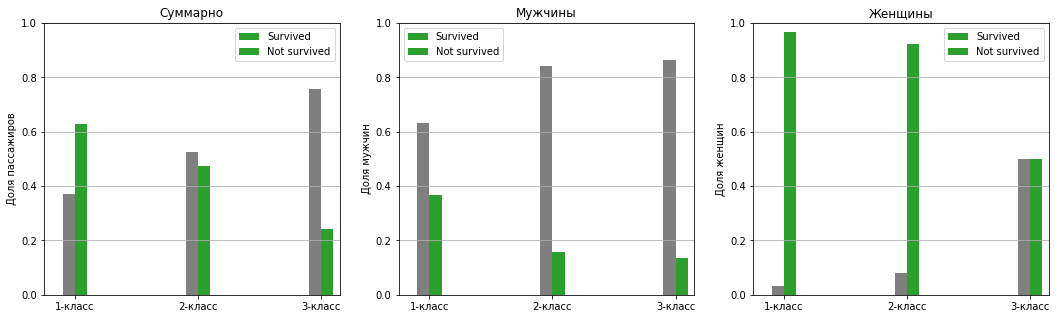

In [10]:
#выделение требуемых признаков
df = df_train[['Pclass','Survived', 'Sex']]

#коэффициенты нормировки
norma_g = df.groupby('Pclass').count()
norma_m = df[df['Sex']==0].groupby('Pclass').count()
norma_f = df[df['Sex']==1].groupby('Pclass').count()

fig = plt.figure(figsize=(18,5))

#связь между классом и результатом
data1 = df[df['Survived']==1].groupby('Pclass').count()/norma_g
data0 = df[df['Survived']==0].groupby('Pclass').count()/norma_g
create_axes_class_sex(1, data1, data0, 'Суммарно', 'Доля пассажиров')

data1 = df[(df['Survived']==1)&(df['Sex']==0)].groupby('Pclass').count()/norma_m
data0 = df[(df['Survived']==0)&(df['Sex']==0)].groupby('Pclass').count()/norma_m
create_axes_class_sex(2, data1, data0, 'Мужчины', 'Доля мужчин')

data1 = df[(df['Survived']==1)&(df['Sex']==1)].groupby('Pclass').count()/norma_f
data0 = df[(df['Survived']==0)&(df['Sex']==1)].groupby('Pclass').count()/norma_f
create_axes_class_sex(3, data1, data0, 'Женщины', 'Доля женщин')

Для всех пассажиров, независимо от пола, доля выживших существенно снижается по мере увеличения цифры класса. Другими словами, существует сильная корреляция между классом и полом пассажира и благополучным исходом.

**Исход в зависимости от возраста**

Сначала посмотрим на общее распределение возрастов пассажиров с помощью гистограммы и оценим шансы на выживание в зависимости от возрастной группы пассажира, разделиим их на 20 категорий: от 0 до 80 лет.

In [11]:
df_train['AgeBand'] = pd.cut(df_train['Age'], range(0,81,4))

In [12]:
#выделение требуемых признаков
df = df_train[['Age', 'AgeBand', 'Survived', 'Sex']]

In [13]:
#создание набора гистограмм
def create_axes_hist_age(sbp, data, tlt):
    bins = np.linspace(0, 80, 20)
    ax = fig.add_subplot(1,3,sbp)
    data.plot(kind='hist', ec='k', bins=bins, ax=ax)
    ax.grid(axis='y')
    ax.set_title(tlt)
    ax.set_ylim(0, 270)
    ax.set_ylabel('Пассажиры')
    ax.set_xlabel('Возраст, лет')

In [14]:
#создание набора графиков
def create_axes_age(sbp, data, tlt, ylbl):
    ax = fig.add_subplot(1, 3, sbp)
    data.plot.bar(color='tab:green', ax=ax, width=.5, align='center')
    ax.grid(axis='y')
    ax.set_title(tlt)
    ax.set_ylim(0,1)
    ax.set_xlim(-0.7,19.7)
    ax.set_ylabel(ylbl)
    ax.set_xlabel('Возрастные группы')
    ax.tick_params(axis='x', labelrotation=0)
    formatter = matplotlib.ticker.FormatStrFormatter('%.0f')
    ax.xaxis.set_major_formatter(formatter)
    ax.legend(loc='upper left')

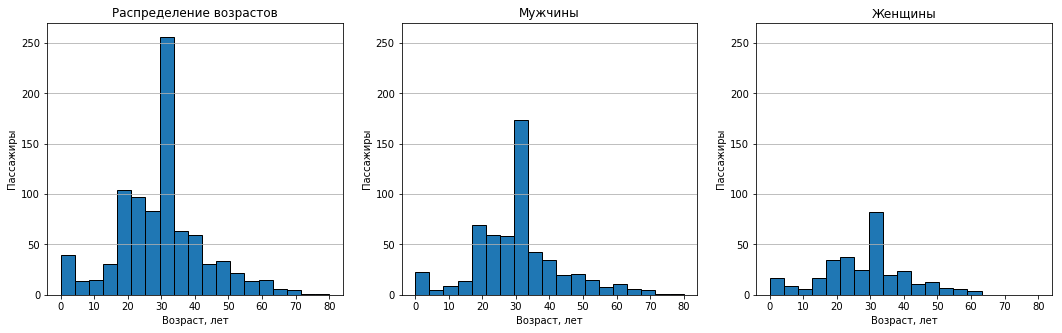

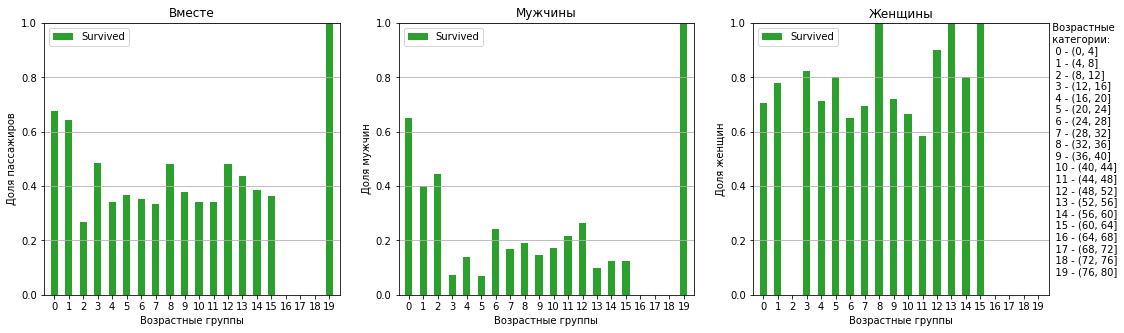

In [15]:
fig = plt.figure(figsize=(18,5))

data = df['Age']
create_axes_hist_age(1, data, 'Распределение возрастов')

data = df['Age'][df['Sex']==0]
create_axes_hist_age(2, data, 'Мужчины')

data = df['Age'][df['Sex']==1]
create_axes_hist_age(3, data, 'Женщины')

fig = plt.figure(figsize=(18,5))

group = df[['AgeBand', 'Survived']].groupby(['AgeBand'],as_index=False).mean().sort_values(by='AgeBand',ascending=True)
create_axes_age(1, group, 'Вместе', 'Доля пассажиров')

group = df[['AgeBand', 'Survived']][df['Sex']==0].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand',ascending=True)
create_axes_age(2, group, 'Мужчины', 'Доля мужчин')

group = df[['AgeBand', 'Survived']][df['Sex']==1].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand',ascending=True)
create_axes_age(3, group, 'Женщины', 'Доля женщин')

#расшифровка категорий
a = ['   {0} - {1}\n'.format(i,x) for i,x in enumerate(df['AgeBand'].unique().categories)]
plt.annotate('  Возрастные\n  категории:\n'+''.join(a), xy=(19.5,1), va='top')
plt.show()

Если убрать из рассмотрения крайние выбросы первой и последней возрастной категории (0-4 и 76-80 лет), умеренная зависимость между возрастом и шансами на выживание присутствует.

**Зависимость от размера семьи на борту**

Проанализируем шансы на выживание в зависимости от количества родственников на борту. Можно предварительно предположить, что пассажиры, путешествующие в одиночестве, имеют больший шанс на спасение. Давайте визуализируем долю выживших пассажиров в зависимости от размера семьи на борту.

In [16]:
df = df_train[['Family','Survived', 'Sex']]

In [17]:
#создание набора графиков
def create_axes_family(sbp, data1, data0, tlt, ylbl):
    ax = fig.add_subplot(1, 3, sbp)
    data1.sort_values(by=['Family'], inplace=True)
    data0.sort_values(by=['Family'], inplace=True)
    data1.plot.bar(color='tab:green', ax=ax, width=.3, align='edge')
    data0.plot.bar(color='tab:gray' , ax=ax, width=-.3, align='edge')
    ax.grid(axis='y')
    ax.set_title(tlt)
    ax.set_ylim(0,1)
    ax.set_ylabel(ylbl)
    ax.set_xlabel('# of relatives')
    ax.tick_params(axis='x', labelrotation=0)
    ax.legend(['Survived', 'Not survived'])

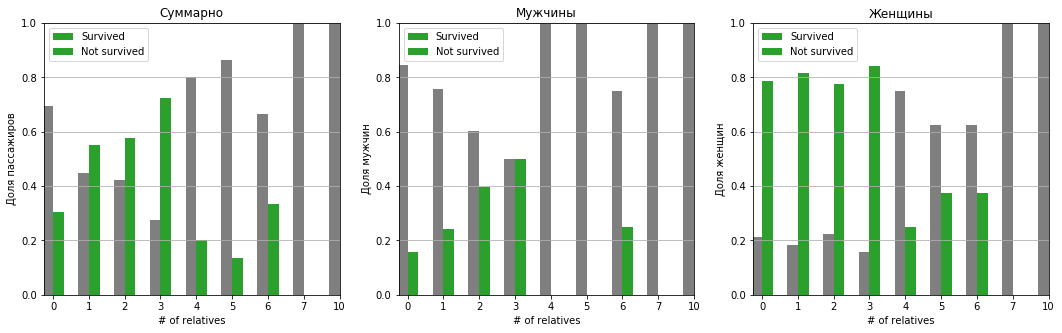

In [18]:
fig = plt.figure(figsize=(18,5))

#коэффициенты нормировки
norma_g = df.groupby('Family').count()
norma_m = df[df['Sex']==0].groupby('Family').count()
norma_f = df[df['Sex']==1].groupby('Family').count()

#связь между 'Family' и результатом
data1 = df[df['Survived']==1].groupby('Family').count()/norma_g
data0 = df[df['Survived']==0].groupby('Family').count()/norma_g
create_axes_family(1, data1, data0, 'Суммарно', 'Доля пассажиров')

data1 = df[(df['Survived']==1)&(df['Sex']==0)].groupby('Family').count()/norma_m
data0 = df[(df['Survived']==0)&(df['Sex']==0)].groupby('Family').count()/norma_m
create_axes_family(2, data1, data0, 'Мужчины', 'Доля мужчин')

data1 = df[(df['Survived']==1)&(df['Sex']==1)].groupby('Family').count()/norma_f
data0 = df[(df['Survived']==0)&(df['Sex']==1)].groupby('Family').count()/norma_f
create_axes_family(3, data1, data0, 'Женщины', 'Доля женщин')

В первых 4 группах шансы на выживание линейно растут.  
Интересная особенность:  
- Для мужчин с количеством родственников на борту 4, 5, 7, 10 шансы выжить стремятся к нулю.  
- Для женщин относительно безопасно в первых 4 группах и фатально попадание в группу 7 и 10

Наше первоначальное предположение не подтвердилось, люди путешествующие в одиночестве не имеют преимуществ. Дополнительно мы выявили новую сложную взаимосвязь в виде неких "крайне неудачных" значений параметра Family. Не пытаясь объяснить природу этой взаимосвязи, давайте попробуем оценить ее кореляцию с результатом и проверить, стоит ли учитывать ее при обучении модели. Для этого создадим бинарный признак 'Unlucky' по следующему принципу: для всех пассажиров с количеством родственников 7 и 10 он будет равен 1, таким же он будет для мужчин с количеством родственников 4 и 5, во всех остальных случаях - 0.

In [19]:
df_train['Unlucky'] = 0
df_train['Unlucky'][(df_train['Family']==7) | (df_train['Family']==10)] = 1
df_train['Unlucky'][(df_train['Sex']==0) & ((df_train['Family']==4)|(df_train['Family']==5))] = 1

Проверим корреляцию целевого параметра с новым признаком:

In [20]:
df_train.loc[:, 'Unlucky'].corr(df_train['Survived'])

-0.14732821682521155

Видим явную отрицательную зависимость, включаем этот параметр в обучение.

**По результатам анализа для обучения модели мы выбираем следующие признаки: Age, Sex, Pclass, SibSp, Parch, Unlucky.**

In [21]:
X_train = df_train[['Age', 'Sex', 'Pclass', 'Unlucky', 'SibSp', 'Parch']]
y_train = df_train['Survived']

### Обучение дефолтных моделей и выбор лучшей

Прежде чем обучать модели, давайте разберемся, какие значения точности окажутся приемлимыми в данной задаче. Для этого воспользуемся концепцией _константной_ модели.  
Константная модель - это алгоритм предсказывающий одно и то же постоянное значение (например, 0) для всех объектов выборки. Как воспользоваться такой моделью? Из постановки задачи следует, что доля выживших пассажиров составила 100-1502/2224 = 32%. Тогда без дополнительных усилий можно сгенирировать константное предсказание, состоящее из одних 0 (никто не выжил) и гарантированно получить точность близкую к 100-32 = 68%. Логично предположить, что эффективно обученная модель должна иметь точность **> 68%**.

Составим список моделей с пераметрами по умолчанию.

In [22]:
models = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(n_estimators=100),
    ensemble.BaggingClassifier(n_estimators=100),
    ensemble.ExtraTreesClassifier(n_estimators=100),
    ensemble.GradientBoostingClassifier(n_estimators=100),
    ensemble.RandomForestClassifier(n_estimators=100),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(max_iter=1000),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis()
]

Для оценки качества моделей мы воспользуемся стандартной метрикой, определяющей точность по кросс-валидации (на 10 фолдов) с оценкой результата по контрольной выборке, не включенной в обучение и валидацию. Разобъем обучающую выборку в пропорции 60% обучение, 30% валидация, 10% контроль.  
Создадим сводную таблицу, в которую запишем характеристики каждой проверяемой модели:
- Model Name - название модели;  
- Train Accuracy Mean - усредненный показатель точности на кросс-валидации;  
- Test Accuracy Mean -  усредненный показатель точности на контрольной выборке;
- Test Accuracy 3*STD - три-сигма диапазон показателя точности на контрольной выборке;
- Time - время, затраченное на вычисления;
- Parameters - параметры дефолтной модели.  


И в конце, отсортируем таблицу по убыванию точности на контроле.

In [23]:
def get_model_compare_table(n=10):
    m_columns = ['Model Name', 'Train Accuracy Mean', 'Test Accuracy Mean', 'Test Accuracy 3*STD' , 'Time']
    table = pd.DataFrame(columns=m_columns) #пустая таблица моделей
    cv_split = model_selection.ShuffleSplit(n_splits=n, test_size =.3, train_size =.6, random_state=4) #разбиение выборки 60:30:10
    for i, model in enumerate(models):
        table.loc[i, 'Model Name'] = model.__class__.__name__
        table.loc[i, 'Parameters'] = str(model.get_params())
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=cv_split, return_train_score=True)
        table.loc[i, 'Time'] = cv_results['fit_time'].mean()
        table.loc[i, 'Train Accuracy Mean'] = cv_results['train_score'].mean()
        table.loc[i, 'Test Accuracy Mean'] = cv_results['test_score'].mean()
        table.loc[i, 'Test Accuracy 3*STD'] = cv_results['test_score'].std() * 3
    table.sort_values(by=['Test Accuracy Mean'], ascending=False, inplace=True)
    return table

In [24]:
table_0 = get_model_compare_table(n=10)
table_0

,Model Name,Train Accuracy Mean,Test Accuracy Mean,Test Accuracy 3*STD,Time,Parameters
3,GradientBoostingClassifier,0.88764,0.807463,0.0586379,0.0539748,"{'criterion': 'friedman_mse', 'init': None, 'l..."
0,AdaBoostClassifier,0.8397,0.803358,0.0662342,0.0923625,"{'algorithm': 'SAMME.R', 'base_estimator': Non..."
14,NuSVC,0.873783,0.800373,0.0799805,0.0744641,"{'cache_size': 200, 'class_weight': None, 'coe..."
4,RandomForestClassifier,0.930337,0.800373,0.0625765,0.0818335,"{'bootstrap': True, 'class_weight': None, 'cri..."
1,BaggingClassifier,0.930337,0.797015,0.056682,0.0962348,"{'base_estimator': None, 'bootstrap': True, 'b..."
13,SVC,0.868165,0.795896,0.0744298,0.0640581,"{'C': 1.0, 'cache_size': 200, 'class_weight': ..."
10,BernoulliNB,0.792509,0.795149,0.0845798,0.00156233,"{'alpha': 1.0, 'binarize': 0.0, 'class_prior':..."
7,RidgeClassifierCV,0.801498,0.79291,0.0785578,0.00289831,"{'alphas': array([ 0.1, 1. , 10. ]), 'class_w..."
18,LinearDiscriminantAnalysis,0.801498,0.79291,0.0785578,0.0025991,"{'n_components': None, 'priors': None, 'shrink..."
2,ExtraTreesClassifier,0.930337,0.791418,0.0582627,0.0782195,"{'bootstrap': False, 'class_weight': None, 'cr..."


Максимальную точность на контроле **0.807** показала модель **GradientBoostingClassifier**. Для наглядности визуализируем полученную таблицу.

In [25]:
def visualize_table(data):
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    sns.barplot(x='Test Accuracy Mean', y='Model Name', data=data, palette="Blues_d")
    ax.grid(axis='x')
    ax.set_title('Точность моделей')
    ax.set_ylabel('Model Name')

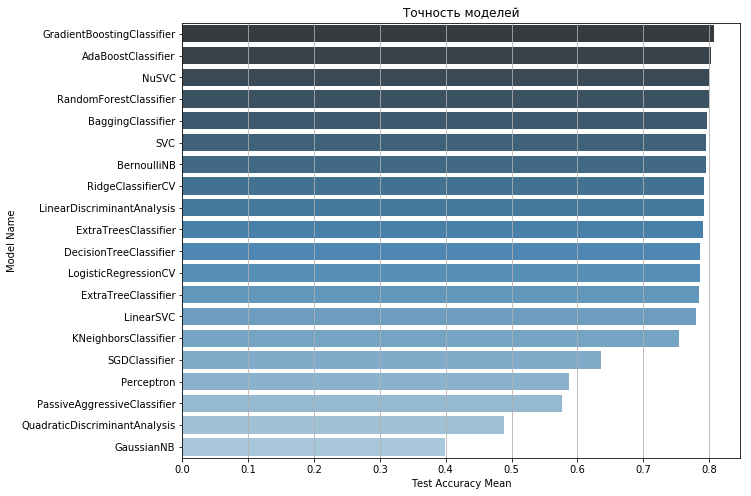

In [26]:
visualize_table(table_0)

Преждем чем выбрать лучшую модель для дальнейшей оптимизации, обратим внимание на то, что простые метрические алгоритмы NuSVC и SVC показали довольно высокий результат, хотя используемые в обучении признаки не были отмасштабированы. Метод опорных весторов крайне чувствителен к масштабу данных: если используемые в обучении признаки сильно различются по абсолютной величине, предсказательная способность алгоритма значительно снижается. Есть смысл, учесть этот аспект и провести повторную оценку точности дефолтных моделей на отмасштабированных данных.

**Масштабирование признаков**

In [27]:
#масштабирование вещественных признаков
X_train = df_train[['Age', 'Sex', 'Pclass', 'Unlucky', 'SibSp', 'Parch']].astype(float)
X_train = preprocessing.StandardScaler().fit(X_train).transform(X_train)
y_train = df_train['Survived']
X_train[0]

array([-0.5924806 , -0.73769513,  0.82737724, -0.18666335,  0.43279337,
       -0.47367361])

In [28]:
table_1 = get_model_compare_table(n=10)
table_1

,Model Name,Train Accuracy Mean,Test Accuracy Mean,Test Accuracy 3*STD,Time,Parameters
13,SVC,0.832772,0.829851,0.06356,0.0287904,"{'C': 1.0, 'cache_size': 200, 'class_weight': ..."
14,NuSVC,0.824345,0.819403,0.0837984,0.0360112,"{'cache_size': 200, 'class_weight': None, 'coe..."
3,GradientBoostingClassifier,0.88764,0.807463,0.0579933,0.0490264,"{'criterion': 'friedman_mse', 'init': None, 'l..."
0,AdaBoostClassifier,0.8397,0.803731,0.0651181,0.0948244,"{'algorithm': 'SAMME.R', 'base_estimator': Non..."
7,RidgeClassifierCV,0.801311,0.795149,0.0854641,0.00169897,"{'alphas': array([ 0.1, 1. , 10. ]), 'class_w..."
4,RandomForestClassifier,0.930337,0.793284,0.0664514,0.0805089,"{'bootstrap': True, 'class_weight': None, 'cri..."
1,BaggingClassifier,0.930337,0.793284,0.0560149,0.0987566,"{'base_estimator': None, 'bootstrap': True, 'b..."
18,LinearDiscriminantAnalysis,0.801498,0.79291,0.0785578,0,"{'n_components': None, 'priors': None, 'shrink..."
12,KNeighborsClassifier,0.850375,0.791045,0.0707973,0.000999594,"{'algorithm': 'auto', 'leaf_size': 30, 'metric..."
15,LinearSVC,0.80412,0.791045,0.0716768,0.0186095,"{'C': 1.0, 'class_weight': None, 'dual': True,..."


Максимальную точность на контроле **0.829851** показала модель **SVC**, что на 0.02 больше, чем у предыдущего лидера GradientBoostingClassifier. Визуализируем полученную таблицу.

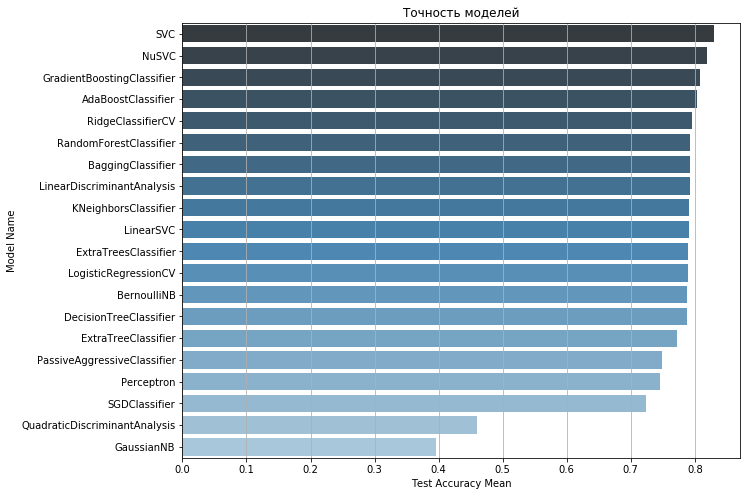

In [29]:
visualize_table(table_1)

Как мы и предполагали, в лидерах оказалась модель **SVC** с результатом на контроле **0.829851**. Для дальнейшей оптимизации выбираем ее.

### Support Vector Classification

Проведем полный перебор параметров модели по сетке с помощью стандартной процедуры GridSearchCV.  
Для этого сначала создадим словарь параметров для перебора.

In [30]:
parameter_grid = {
    'C': [0.001, 0.1, 1, 10, 100, 1000],
    'gamma': ['auto', 'scale'],
    'kernel': ['poly', 'linear', 'rbf', 'sigmoid'], 
    'degree': [2, 3],
}

Создадим объект GridSearchCV.

In [31]:
grid_svc = model_selection.GridSearchCV(svm.SVC(), parameter_grid, 
                                        scoring='accuracy', cv=3, return_train_score=True)

Произведем обучение модели. _Warning! Процесс занимает порядка 10 минут._

In [32]:
%%time
grid_svc.fit(X_train, y_train)

Wall time: 12min 15s


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.1, 1, 10, 100, 1000], 'gamma': ['auto', 'scale'], 'kernel': ['poly', 'linear', 'rbf', 'sigmoid'], 'degree': [2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

Помотрим на параметры лучшей модели.

In [33]:
print(grid_svc.best_score_) #оценка accuracy
print(grid_svc.best_params_) #словарь параметров

0.8271604938271605
{'C': 1, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}


Можем ли мы ускорить процесс обучения сетки? Воспользуемся процедурой _RandomizedSearchCV_, которая не проверяет все возможные сочетания, а только выборочные. Воспользуемся словарем параметров, созданным ранее. 

Создадим объект GridSearchCV.

In [34]:
grid_svc_random = model_selection.RandomizedSearchCV(svm.SVC(), parameter_grid, 
                                                     scoring='accuracy', cv=3, n_iter=20, 
                                                     random_state=0, return_train_score=True)

Произведем обучение модели. _Warning! Процесс занимает порядка 3 минут._

In [35]:
%%time
grid_svc_random.fit(X_train, y_train)

Wall time: 3min 15s


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
          fit_params=None, iid='warn', n_iter=20, n_jobs=None,
          param_distributions={'C': [0.001, 0.1, 1, 10, 100, 1000], 'gamma': ['auto', 'scale'], 'kernel': ['poly', 'linear', 'rbf', 'sigmoid'], 'degree': [2, 3]},
          pre_dispatch='2*n_jobs', random_state=0, refit=True,
          return_train_score=True, scoring='accuracy', verbose=0)

Параметры лучшей модели.

In [36]:
print(grid_svc_random.best_score_) #оценка accuracy для лучшей модели
print(grid_svc_random.best_params_) #словарь параметров этой модели

0.819304152637486
{'kernel': 'rbf', 'gamma': 'scale', 'degree': 2, 'C': 10}


Точность второй модели получилась чуть хуже, параметры моделей не совпадают. Воспользуемся обеими моделями и проверим их точность на тестовой выборке.

## Подготовка отчетов для сабмита

Стандартная предобработка тестового датасета.

In [37]:
df_test = preprocessing_data('test.csv')
df_test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Family
0,892,3,0.0,34.5,0,0,0
1,893,3,1.0,47.0,1,0,1
2,894,2,0.0,62.0,0,0,0
3,895,3,0.0,27.0,0,0,0
4,896,3,1.0,22.0,1,1,2


Добавление признака "Unlucky".

In [38]:
df_test['Unlucky'] = 0
df_test['Unlucky'][(df_test['Family']==7) | (df_test['Family']==10)] = 1
df_test['Unlucky'][(df_test['Sex']==0) & ((df_test['Family']==4)|(df_test['Family']==5))] = 1

Масштабирование признаков.

In [39]:
X_test = df_test[['Age', 'Sex', 'Pclass', 'Unlucky', 'SibSp', 'Parch']].astype(float)
X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test)
X_test[0]

array([ 0.3349926 , -0.75592895,  0.87348191, -0.17192048, -0.49947002,
       -0.4002477 ])

**Генерация предсказаний модели, полученной полным перебором параметров.**

In [40]:
y_hat = grid_svc.predict(X_test)

Форматирование и сохранение датасета.

In [41]:
report_df = pd.DataFrame(y_hat).join(df_test['PassengerId'])
report_df.set_index('PassengerId', inplace=True)
report_df.rename(columns={0 : 'Survived'}, inplace=True)
report_df.head()

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1


In [42]:
report_df.to_csv('report15.csv')

<span style="color:red">**17.04.2019 - Public Score 0.79425**</span>

**Генерация предсказаний модели, полученной случайным неполным перебором параметров.**

In [43]:
y_hat = grid_svc_random.predict(X_test)

Форматирование и сохранение датасета.

In [44]:
report_df = pd.DataFrame(y_hat).join(df_test['PassengerId'])
report_df.set_index('PassengerId', inplace=True)
report_df.rename(columns={0 : 'Survived'}, inplace=True)
report_df.to_csv('report16.csv')
report_df.head()

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,0


<span style="color:red">**17.04.2019 - Public Score 0.76555**</span>